### How sensitive are the SHAP values to the chosen background data?

**Used for the description of Figures 9 and S6 (concerning robustness)**

It could apparently suffice to use one sample as background data: <br>
https://stackoverflow.com/questions/66805128/shap-for-a-single-data-point-instead-of-average-prediction-of-entire-dataset

Best explanation for the background set https://shap.readthedocs.io/en/latest/generated/shap.explainers.Sampling.html:

*The background dataset to use for integrating out features. To determine the impact of a feature, that feature is set to “missing” and the change in the model output is observed. Since most models aren’t designed to handle arbitrary missing data at test time, we simulate “missing” by replacing the feature with the values it takes in the background dataset.*

We want $B_f = B_g$. The base value is computed as the average prediction of the NN on the background data. For this should I: <br>
a) Use just one background sample? This is often recommended. And prescribe the base value. <br>
b) Use 100 background samples. And prescribe the base value? <br>
c) Construct the background dataset for the QUBICC model so that $B_f = B_g$ <br>

Can we satisfy the additivity property by prescribing the base value, i.e. would a) or b) make sense?

**I'm not sure why, but a) and b) do not work as the SHAP values are independent of the base value/expected_value that I manually assign/prescribe.**

--> We follow c) 

It would not make sense to the same dataset as the background set for $f$ and $g$ since then surely $B_f \neq B_g$. So we take subsets of their respective training sets as usual.

In [1]:
import os
import sys
import gc
import time
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import shap

from tensorflow.keras.models import load_model
from tensorflow import nn 
import tensorflow as tf

# Add path with my_classes to sys.path
sys.path.insert(0, '/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/')

import importlib
import my_classes
importlib.reload(my_classes)

from my_classes import load_data
from my_classes import read_mean_and_std

# np.random.seed(10)
np.random.seed(100)

In [2]:
root_path = '/pf/b/b309170'
# data_path = os.path.join(root_path,
#                          'my_work/NARVAL/data_var_vertinterp_R02B05')
model_path = os.path.join(root_path,
                          'workspace_icon-ml/cloud_cover_parameterization/grid_column_based_QUBICC_R02B05/saved_models')

### We use SHAP on the R2B5 NARVAL data 

In [3]:
# Load data
ORDER_OF_VARS_NARVAL = ['qv', 'qc', 'qi', 'temp', 'pres', 'zg', 'fr_land', 'clc']
data_dict = load_data(source='narval', days='all', vert_interp=True, resolution='R02B05', 
                    order_of_vars=ORDER_OF_VARS_NARVAL)

qv
qc
qi
temp
pres


In [4]:
# Are there any bad data points
ta_is_0 = np.where(data_dict['temp'] == 0)
for i in range(3):
    assert ta_is_0[i].size == 0

del ta_is_0
gc.collect()

2923

In [5]:
(TIME_STEPS, VERT_LAYERS, HORIZ_FIELDS) = data_dict['clc'].shape

In [6]:
try:
    #Reshaping into nd-arrays of equaling shapes (don't reshape in the vertical)
    data_dict['zg'] = np.repeat(np.expand_dims(data_dict['zg'], 0), TIME_STEPS, axis=0)
    data_dict['fr_land'] = np.repeat(np.expand_dims(data_dict['fr_land'], 0), TIME_STEPS, axis=0)
except:
    pass

In [7]:
# One sample should contain a column of information
data_dict_reshaped = {}

for key in data_dict.keys():
    if data_dict[key].shape[1] == VERT_LAYERS:  
        # Removing data above 21kms
        for i in range(4, VERT_LAYERS):
            new_key = '{}{}{:d}'.format(key,'_',(i+17)) # Should start at 21
            data_dict_reshaped[new_key] = np.reshape(data_dict[key][:,i,:], -1)
    else:
        data_dict_reshaped[key] = np.reshape(data_dict[key], -1)

In [8]:
#Converting dict into a DataFrame-object 
df = pd.DataFrame.from_dict(data_dict_reshaped)
df.head()

,qv_21,qv_22,qv_23,qv_24,qv_25,qv_26,qv_27,qv_28,qv_29,qv_30,...,clc_38,clc_39,clc_40,clc_41,clc_42,clc_43,clc_44,clc_45,clc_46,clc_47
0,0.000003,0.000003,0.000003,0.000003,0.000006,0.000024,0.000089,0.000198,0.000254,0.000111,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000003,0.000003,0.000003,0.000003,0.000005,0.000020,0.000099,0.000155,0.000234,0.000091,...,0.0,0.000827,0.001540,0.068071,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000003,0.000003,0.000003,0.000003,0.000006,0.000027,0.000031,0.000106,0.000218,0.000140,...,0.0,0.729135,0.202046,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000003,0.000003,0.000003,0.000002,0.000007,0.000023,0.000085,0.000273,0.000234,0.000278,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000003,0.000003,0.000003,0.000003,0.000006,0.000027,0.000085,0.000277,0.000229,0.000292,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#Modifies df as well
def split_input_output(dataset):
    output_df = pd.DataFrame()
    for i in range(21, 48):
        output_df['clc_%d'%i] = dataset['clc_%d'%i] # Should start at 21
        del dataset['clc_%d'%i]
    return output_df

In [10]:
output_df = split_input_output(df)

input_narval = np.float32(df)
output_narval = np.float32(output_df)

#### Remove columns that were constant in at least one of the training folds

In [11]:
remove_fields = [27, 28, 29, 30, 31, 32, 135, 136, 137]
(samples_narval, no_of_features) = input_narval.shape
assert no_of_features == 163

input_narval = np.delete(input_narval, remove_fields, axis=1)
no_of_features = no_of_features - len(remove_fields)

#### Scale the data according to the model's mean and std

In [12]:
mean_2, std_2 = read_mean_and_std(model_path+'/cloud_cover_R2B5_QUBICC/cross_validation_column_based_fold_2.txt')
input_narval = (input_narval-mean_2)/std_2

#### Load the model

In [13]:
os.listdir(model_path+'/cloud_cover_R2B5_QUBICC')

['cross_validation_column_based_fold_3.txt',
 '.ipynb_checkpoints',
 'cross_validation_column_based_fold_3.h5',
 'delete_this.ipynb',
 'cross_validation_column_based_fold_2.txt',
 'cross_validation_column_based_fold_2.yaml',
 'cross_validation_column_based_fold_2.h5',
 'cross_validation_column_based_fold_1.txt',
 'cross_validation_column_based_fold_3.yaml',
 'scaler_100.txt',
 'cross_validation_column_based_fold_1.h5',
 'cross_validation_column_based_fold_1.yaml']

In [14]:
# custom_objects = {}
# custom_objects['leaky_relu'] = nn.leaky_relu

fold_2 = 'cross_validation_column_based_fold_2.h5'

model_fold_2 = load_model(os.path.join(model_path+'/cloud_cover_R2B5_QUBICC', fold_2))

#### Setting up SHAP

In [19]:
# Load column-based R2B5 training data
path_train_data = '/pf/b/b309170/my_work/icon-ml_data/cloud_cover_parameterization/grid_column_based_QUBICC_R02B05/based_on_var_interpolated_data'
input_train = np.load(path_train_data + '/cloud_cover_input_qubicc.npy', mmap_mode='r')

In [20]:
no_samples_train = 10000

rand_indices_train = np.random.randint(0, input_train.shape[0], no_samples_train)

In [21]:
# Load column-based R2B5 training data
input_train = np.float32(input_train[:, rand_indices_train])
input_train = np.transpose(input_train)
input_train = np.delete(input_train, remove_fields, axis=1)
input_train = (input_train-mean_2)/std_2

In [79]:
no_samples_narval = 100  # Set to 1 or 100
rand_indices_narval = np.random.randint(0, input_narval.shape[0], no_samples_narval)

#### One background sample

In [80]:
#initialize js methods for visualization
shap.initjs()

# It takes any combination of a model and masker (usually the training data!) and 
# returns a callable subclass object that implements the particular estimation algorithm 
# (e.g. 'kernel' or 'deep') that was chosen.
# Data is taken to compute the base value.
explainer_shap = shap.DeepExplainer(model=model_fold_2, data=input_train[:1])

In [82]:
shap_values = explainer_shap.shap_values(X=input_narval[rand_indices_narval], check_additivity=True)   

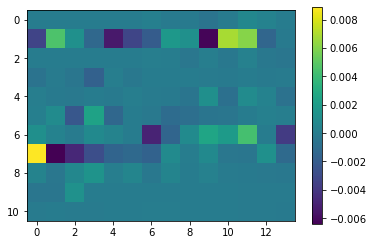

In [84]:
mean_shap_values = np.mean(shap_values[0], axis=0, dtype=np.float64)
plt.imshow(np.reshape(mean_shap_values, (11, 14)))
plt.colorbar()

#### 100 background samples 

In [85]:
explainer_shap = shap.DeepExplainer(model=model_fold_2, data=input_train[:100])

In [86]:
shap_values = explainer_shap.shap_values(X=input_narval[rand_indices_narval], check_additivity=True)   

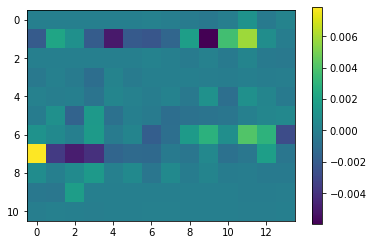

In [87]:
mean_shap_values = np.mean(shap_values[0], axis=0, dtype=np.float64)
plt.imshow(np.reshape(mean_shap_values, (11, 14)))
plt.colorbar()

#### One background sample with modified base value

In [126]:
explainer_shap = shap.DeepExplainer(model=model_fold_2, data=input_train[:1])

In [127]:
add = 10**4
mean_clc_narval_r2b5 = np.array([452345,3.17990944e-04,2.04944345e-01,1.76013253e+00,4.62402318e+00,7.63475259e+00,7.87796339e+00,6.02623801e+00,4.04229306e+00,2.94679257e+00,2.10138767e+00,1.76757824e+00,2.17665910e+00,2.81615928e+00,2.47919885e+00,1.87821508e+00,2.13513892e+00,2.94405649e+00,4.25541137e+00,6.60534415e+00,1.02412513e+01,1.34888487e+01,1.18371291e+01,5.06768331e+00,9.86314478e-01,2.94889349e-01,1.40681544e-01])
explainer_shap.expected_value = tf.constant(mean_clc_narval_r2b5+add)

In [128]:
shap_values = explainer_shap.shap_values(X=input_narval[rand_indices_narval], check_additivity=True)   

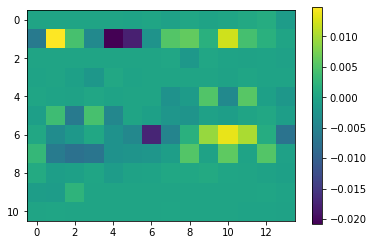

In [129]:
mean_shap_values = np.mean(shap_values[0], axis=0, dtype=np.float64)
plt.imshow(np.reshape(mean_shap_values, (11, 14)))
plt.colorbar()

#### 100 background samples with modified base value

In [92]:
explainer_shap = shap.DeepExplainer(model=model_fold_2, data=input_train[:100])

In [93]:
mean_clc_narval_r2b5 = [2.15509865e-07,3.17990944e-04,2.04944345e-01,1.76013253e+00,4.62402318e+00,7.63475259e+00,7.87796339e+00,6.02623801e+00,4.04229306e+00,2.94679257e+00,2.10138767e+00,1.76757824e+00,2.17665910e+00,2.81615928e+00,2.47919885e+00,1.87821508e+00,2.13513892e+00,2.94405649e+00,4.25541137e+00,6.60534415e+00,1.02412513e+01,1.34888487e+01,1.18371291e+01,5.06768331e+00,9.86314478e-01,2.94889349e-01,1.40681544e-01]
explainer_shap.expected_value = tf.constant(mean_clc_narval_r2b5)

In [94]:
shap_values = explainer_shap.shap_values(X=input_narval[rand_indices_narval], check_additivity=True)   

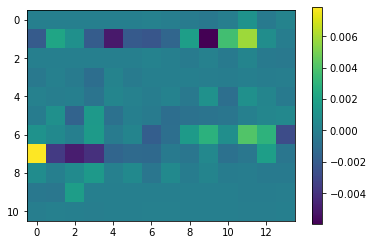

In [95]:
mean_shap_values = np.mean(shap_values[0], axis=0, dtype=np.float64)
plt.imshow(np.reshape(mean_shap_values, (11, 14)))
plt.colorbar()

#### The shap values are actually independent of explainer_shap.expected_value!

In [134]:
explainer_shap = shap.DeepExplainer(model=model_fold_2, data=input_train[:1])

In [135]:
mean_shap_values = []
for add in [0, 10**2, 10**4]:
    mean_clc_narval_r2b5 = np.array([452345,3.17990944e-04,2.04944345e-01,1.76013253e+00,4.62402318e+00,7.63475259e+00,7.87796339e+00,6.02623801e+00,4.04229306e+00,2.94679257e+00,2.10138767e+00,1.76757824e+00,2.17665910e+00,2.81615928e+00,2.47919885e+00,1.87821508e+00,2.13513892e+00,2.94405649e+00,4.25541137e+00,6.60534415e+00,1.02412513e+01,1.34888487e+01,1.18371291e+01,5.06768331e+00,9.86314478e-01,2.94889349e-01,1.40681544e-01])
    explainer_shap.expected_value = tf.constant(mean_clc_narval_r2b5+add)
    shap_values = explainer_shap.shap_values(X=input_narval[rand_indices_narval], check_additivity=True)  
    mean_shap_values.append(np.mean(shap_values[0], axis=0, dtype=np.float64))
    print(shap_values[0][0])

[ 7.23968151e-06 -1.99349868e-05  3.82896926e-06 -1.04541025e-05
 -5.57041794e-04 -5.14343903e-05 -2.48730807e-04 -8.13106752e-04
  4.58750075e-04  1.35029441e-03  2.86085053e-04 -2.39155466e-05
  3.07672663e-03 -7.56224544e-04 -3.20310247e-03  9.13695947e-04
  6.88084985e-03 -1.40816764e-02 -9.51882939e-02 -1.05967225e-01
  2.14522518e-02 -3.38501369e-03  4.00604478e-02  2.33684009e-02
  1.26690196e-02 -1.45010246e-03  1.87171328e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  6.14580756e-04
  1.42883906e-04 -1.87460189e-04 -1.04646719e-03 -2.85899470e-03
  2.64494472e-04 -2.38441973e-04  2.75493384e-04  1.01586819e-04
 -7.45752484e-04 -1.87234956e-03  6.40527497e-04 -8.29965427e-05
  3.19846818e-15  1.13363602e-11  1.85726219e-05  1.99820041e-04
 -3.65407533e-04  4.26501765e-08  6.68751477e-12  1.37196555e-13
 -1.23764417e-15 -2.30263322e-17  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [138]:
assert np.all(mean_shap_values[0] == mean_shap_values[1])
assert np.all(mean_shap_values[0] == mean_shap_values[2])

#### How sensitive are the absolute average SHAP values to the background data?

We usually guarantee $B_f = B_g$ on layer 32 only:

In [96]:
constructed_base = True # Always set equal to True here!
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

if constructed_base:
    r2b5_file = '/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/grid_column_based_QUBICC_R02B05/source_code/shap_values_fold_2_constructed_base_value.txt'
else:
    r2b5_file = '/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/grid_column_based_QUBICC_R02B05/source_code/shap_values_fold_2.txt'

In [97]:
with open(r2b5_file, 'r') as file:
    lines = file.readlines()
    
all_abs_shap_values = []
    
for k in range(10):
    if constructed_base:
        start_read_ind_r2b5 = k*11
    else:
        start_read_ind_r2b5 = 36 
    print(lines[start_read_ind_r2b5])

    if constructed_base:
        start_read_ind_r2b5 += 2

    print(lines[start_read_ind_r2b5+6])
    masv = lines[start_read_ind_r2b5+7].split('[')

    mean_abs_shap_values_r2b5 = np.zeros((27, 154))

    for layer in range(1, 28):
        mean_abs_shap_values_r2b5[layer-1] = np.fromstring(masv[layer][:-1], dtype=np.float16, sep=',')

    # Add the removed fields
    for i in range(6):
        mean_abs_shap_values_r2b5 = np.insert(mean_abs_shap_values_r2b5, 27, np.zeros(27), axis=1)

    for i in range(3):
        mean_abs_shap_values_r2b5 = np.insert(mean_abs_shap_values_r2b5, 135, np.zeros(27), axis=1)

    all_abs_shap_values.append(mean_abs_shap_values_r2b5)

Number of NARVAL samples: 10000

Mean absolute SHAP values:

Number of NARVAL samples: 10000

Mean absolute SHAP values:

Number of NARVAL samples: 10000

Mean absolute SHAP values:

Number of NARVAL samples: 10000

Mean absolute SHAP values:

Number of NARVAL samples: 10000

Mean absolute SHAP values:

Number of NARVAL samples: 10000

Mean absolute SHAP values:

Number of NARVAL samples: 10000

Mean absolute SHAP values:

Number of NARVAL samples: 10000

Mean absolute SHAP values:

Number of NARVAL samples: 10000

Mean absolute SHAP values:

Number of NARVAL samples: 10000

Mean absolute SHAP values:



string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.


zg r2b5 has absolute SHAP values below 0.793
fr_land r2b5 has absolute SHAP values below 0.211



<Figure size 2016x792 with 0 Axes>

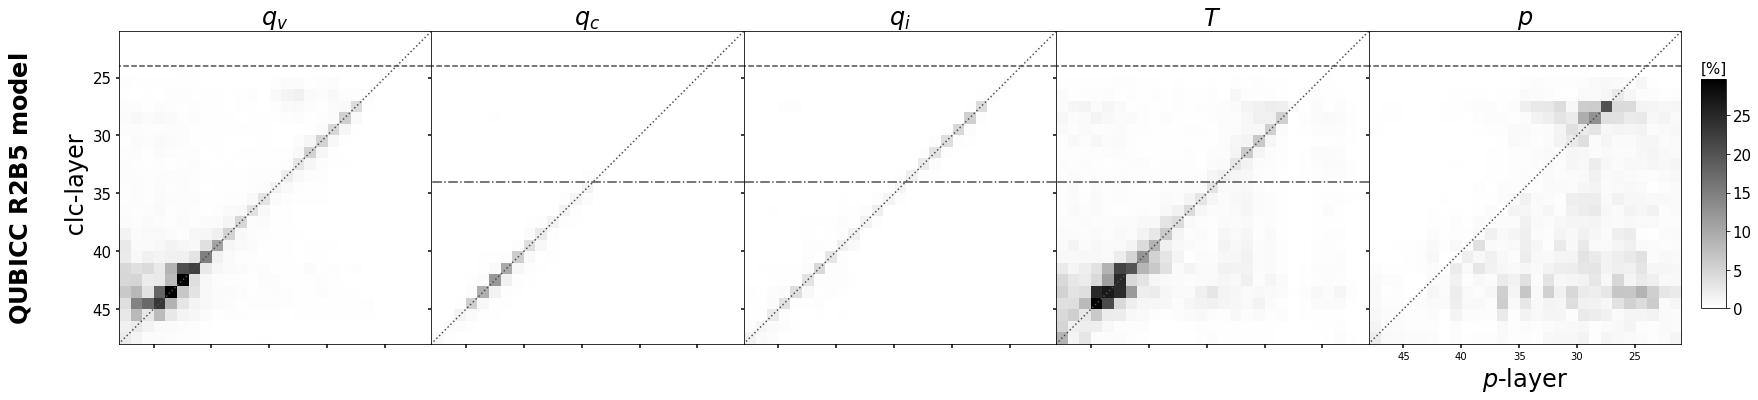

zg r2b5 has absolute SHAP values below 0.792
fr_land r2b5 has absolute SHAP values below 0.212



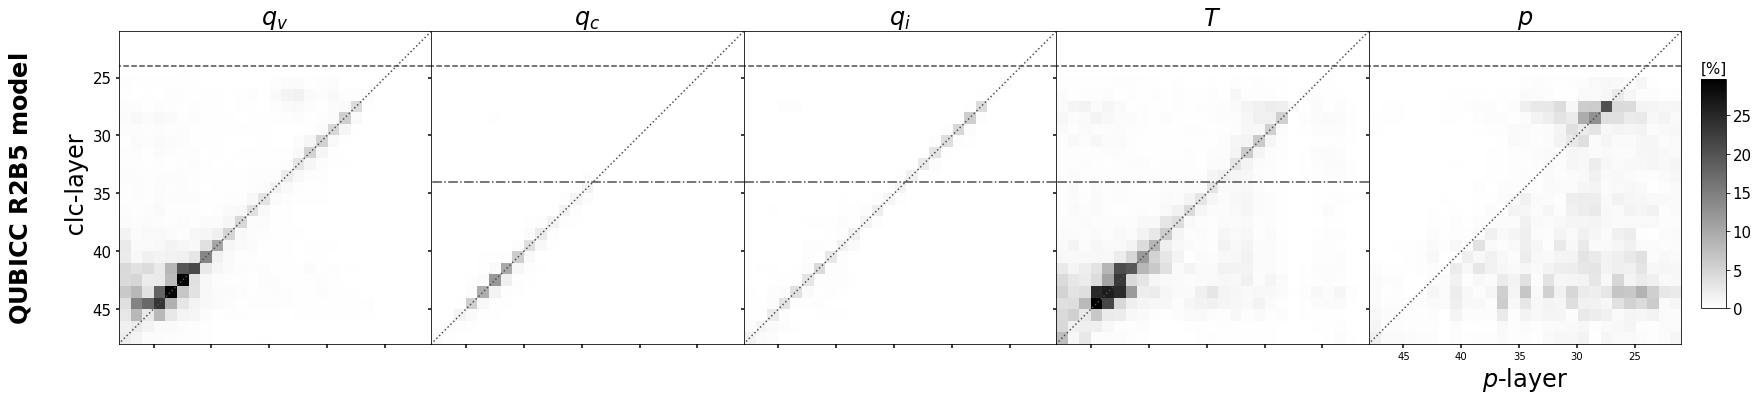

zg r2b5 has absolute SHAP values below 0.787
fr_land r2b5 has absolute SHAP values below 0.215



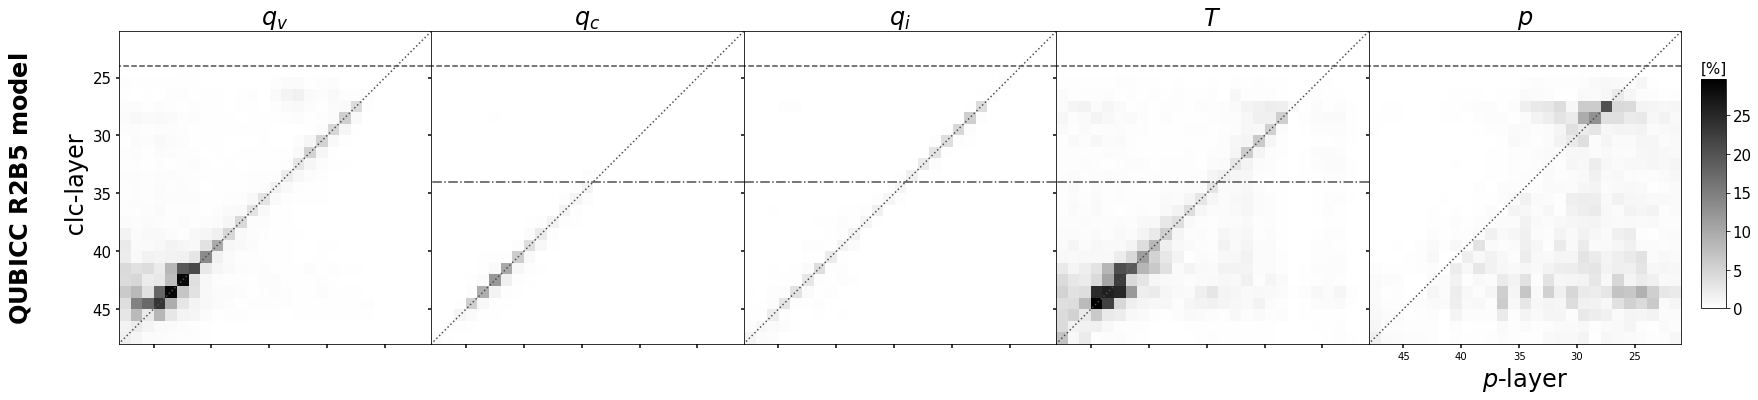

zg r2b5 has absolute SHAP values below 0.787
fr_land r2b5 has absolute SHAP values below 0.213



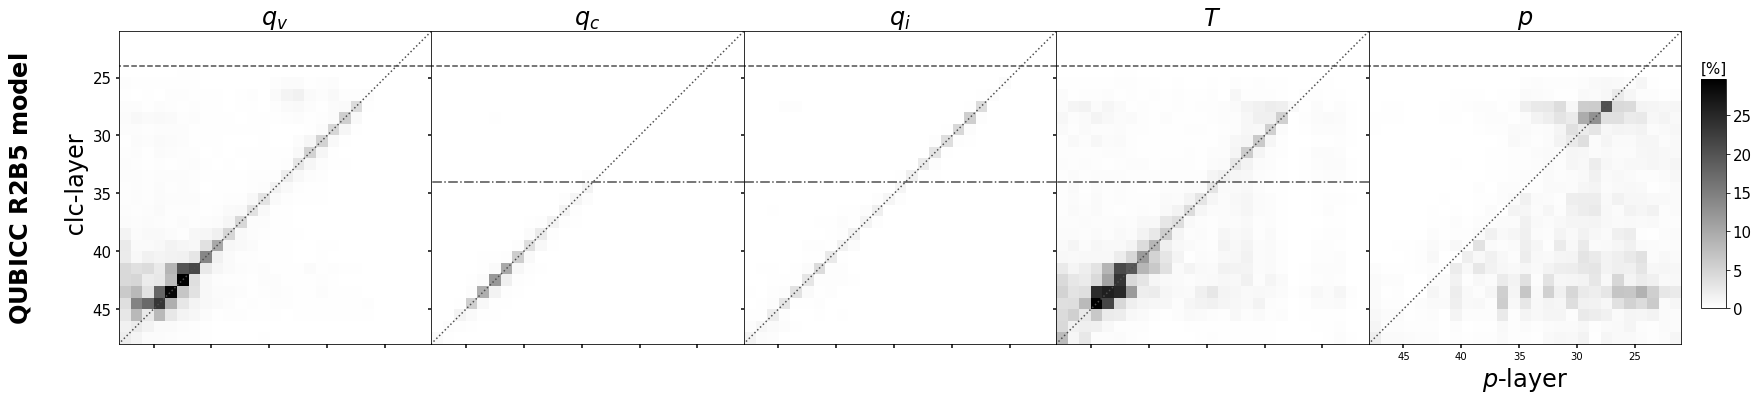

zg r2b5 has absolute SHAP values below 0.787
fr_land r2b5 has absolute SHAP values below 0.214



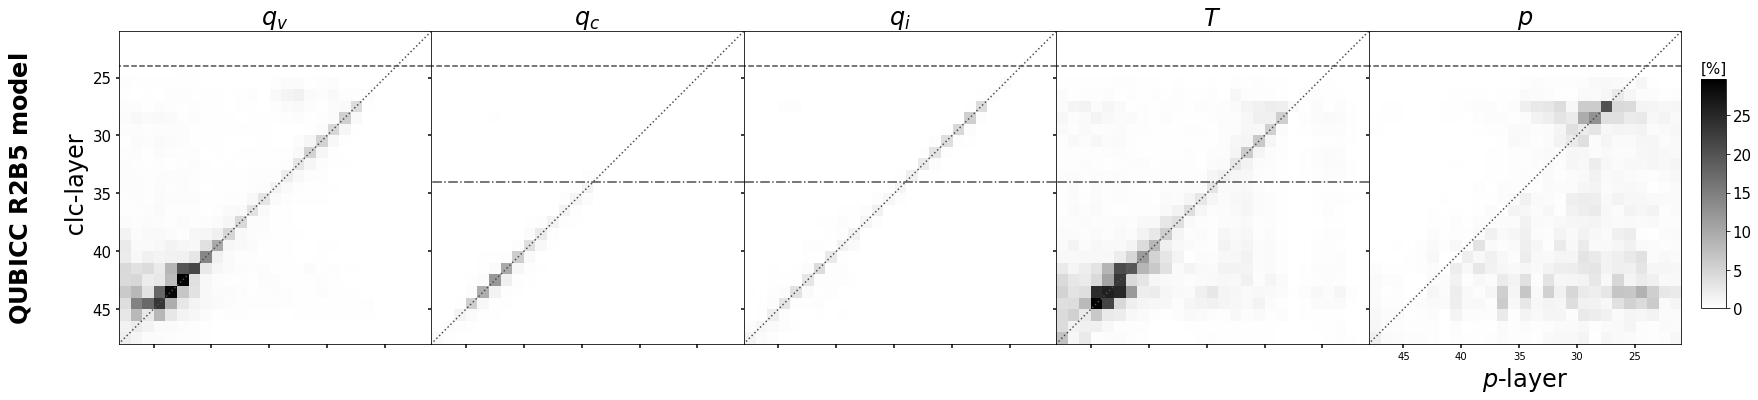

zg r2b5 has absolute SHAP values below 0.786
fr_land r2b5 has absolute SHAP values below 0.213



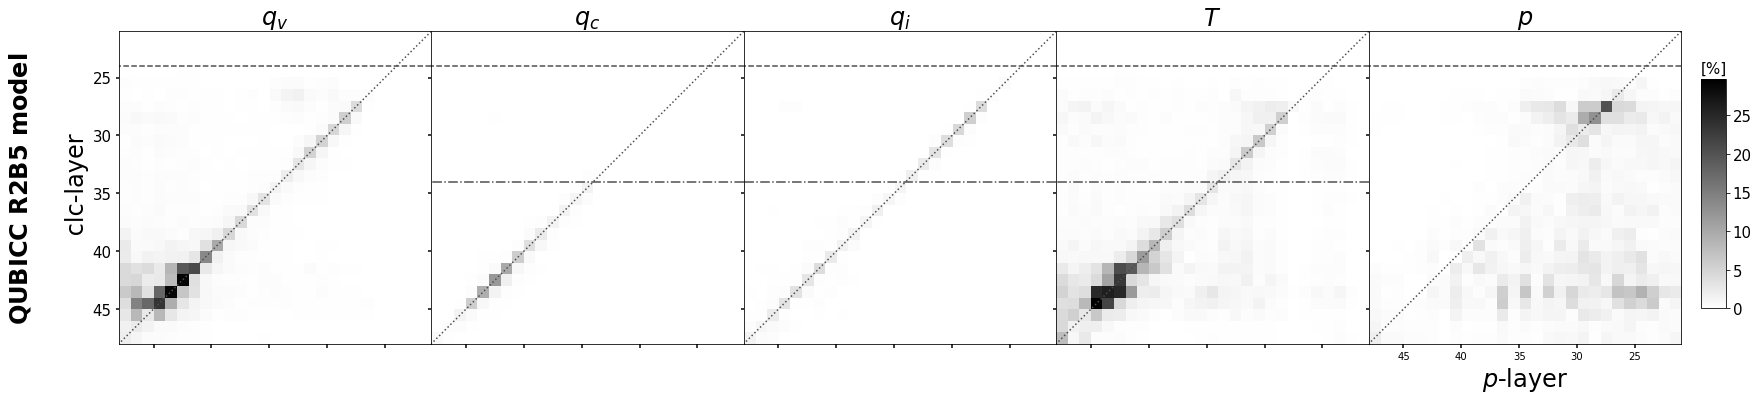

zg r2b5 has absolute SHAP values below 0.783
fr_land r2b5 has absolute SHAP values below 0.215



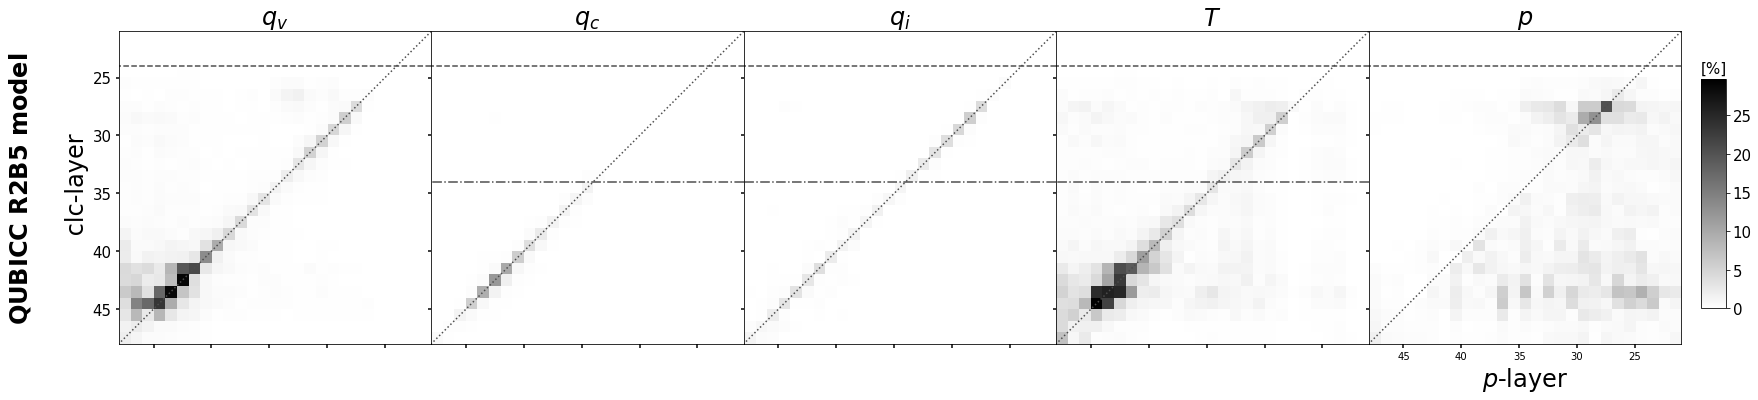

zg r2b5 has absolute SHAP values below 0.783
fr_land r2b5 has absolute SHAP values below 0.213



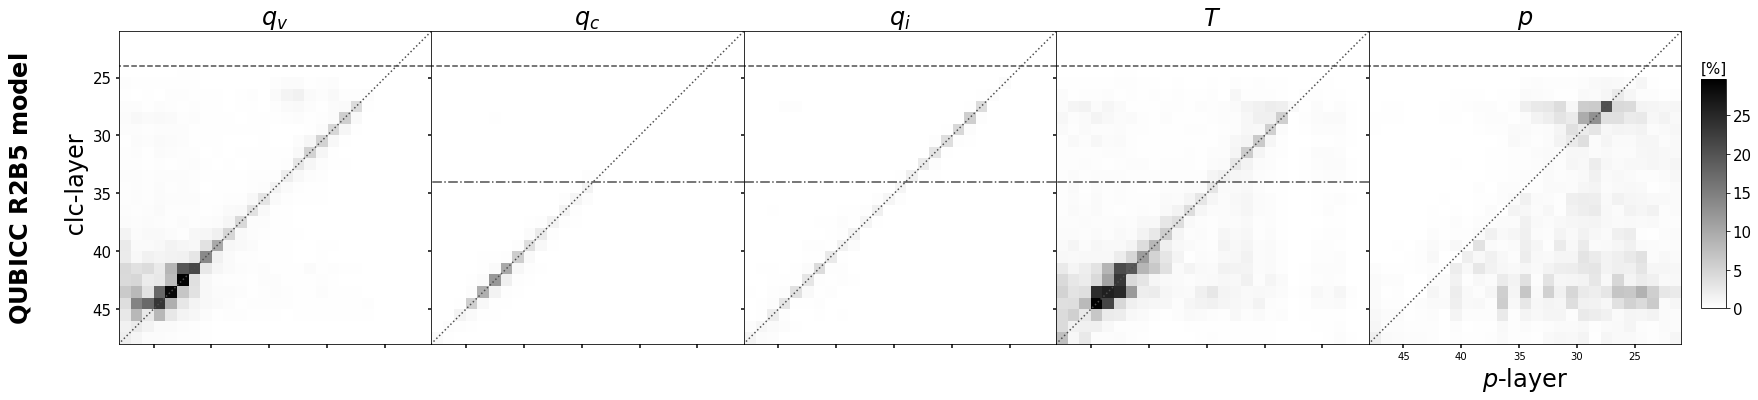

zg r2b5 has absolute SHAP values below 0.783
fr_land r2b5 has absolute SHAP values below 0.212



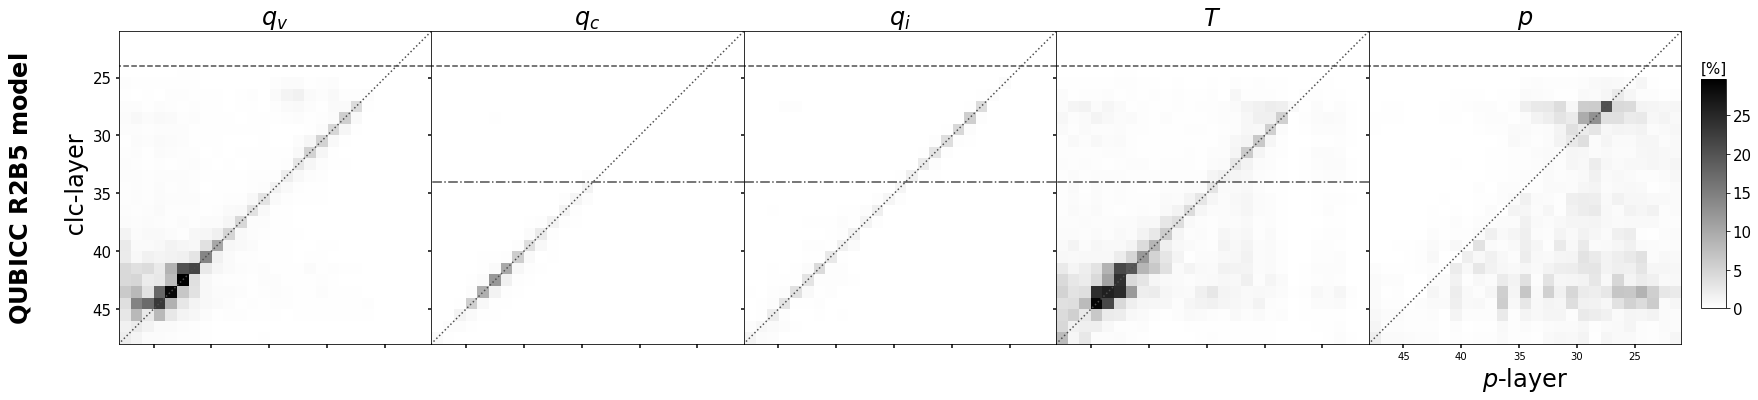

zg r2b5 has absolute SHAP values below 0.789
fr_land r2b5 has absolute SHAP values below 0.212



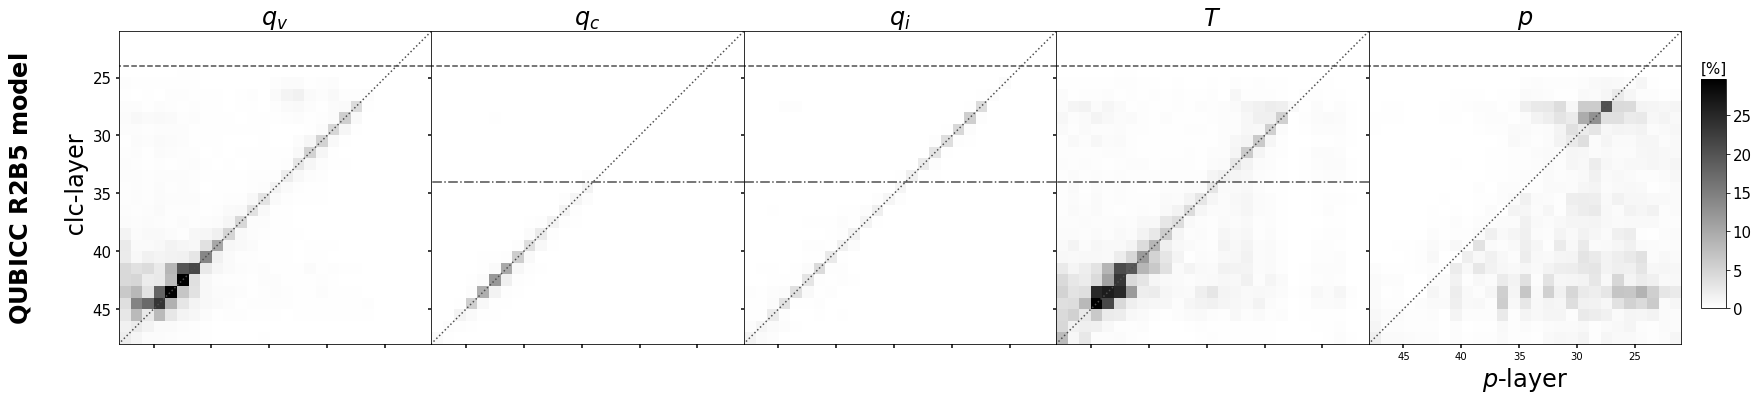

In [98]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(28,11))
# plt.subplots_adjust(bottom=0.1)

label_size = 24 # x-labels, y-labels and titles
tick_label_size = 15

## R2B5 ##

# # To be able to compare the SHAP value colorbar with the one from the R2B4 model, we need to add the difference of the 
# # QUBICC-base and the NARVAL-base value to vmax!
# # According to pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/additional_content/plots_offline_paper/r2b4_mean_clc.ipynb
# # the base value for NARVAL is 3.625 and for QUBICC acc. to qubicc_models_plots.ipynb is 9 (average data_mean_column_clc_qubicc)
# qubicc_base = 9
# narval_base = 3.625
# vmax_r2b4 = 8

# vmin = 0
# vmax = vmax_r2b4 + qubicc_base - narval_base

vmin = 0
vmax_r2b4 = np.max(mean_abs_shap_values_r2b5) 
vmax = vmax_r2b4

cmap_abs = LinearSegmentedColormap.from_list("", ["white","black"])

for k in range(10):
    fig = plt.figure(figsize=(28,11))
    
    # First plot
    ax = fig.add_subplot(151)
    plt.title('$q_v$', fontsize=label_size)
    plt.ylabel(r"$\bf{QUBICC\ R2B5\ model}$" + '\n \n clc-layer', fontsize=label_size)
    ax.plot([21, 48], [21, 48], ls=":", c=".3") # Diagonal
    ax.plot([21, 48], [24, 24], ls="--", c=".3") # Tropopause
    plt.xticks(color='w')
    plt.tick_params(axis='both', labelsize=tick_label_size, width=1.5)
    im_r2b5 = ax.imshow(np.flip(all_abs_shap_values[k][:, :27], axis=1), extent=(48,21,48,21), 
                   vmin=0, vmax=vmax, cmap=cmap_abs)

    # Second plot
    ax = fig.add_subplot(152)
    plt.title('$q_c$', fontsize=label_size)
    ax.plot([21, 48], [21, 48], ls=":", c=".3") # Diagonal
    ax.plot([21, 48], [24, 24], ls="--", c=".3") # Tropopause
    ax.plot([21, 48], [34, 34], ls="-.", c=".3") # Freezing level
    plt.xticks(color='w')
    plt.yticks(color='w')
    plt.tick_params(axis='both', width=1.5)
    im_r2b5 = ax.imshow(np.flip(all_abs_shap_values[k][:, 27:54], axis=1), extent=(48,21,48,21), 
                   vmin=0, vmax=vmax, cmap=cmap_abs)

    # Third plot
    ax = fig.add_subplot(153)
    plt.title('$q_i$', fontsize=label_size)
    ax.plot([21, 48], [21, 48], ls=":", c=".3") # Diagonal
    ax.plot([21, 48], [24, 24], ls="--", c=".3") # Tropopause
    ax.plot([21, 48], [34, 34], ls="-.", c=".3") # Freezing level
    plt.xticks(color='w')
    plt.yticks(color='w')
    plt.tick_params(axis='both', width=1.5)
    im_r2b5 = ax.imshow(np.flip(all_abs_shap_values[k][:, 54:81], axis=1), extent=(48,21,48,21), 
                   vmin=0, vmax=vmax, cmap=cmap_abs)

    # Forth plot
    ax = fig.add_subplot(154)
    plt.title('$T$', fontsize=label_size)
    ax.plot([21, 48], [21, 48], ls=":", c=".3") # Diagonal
    ax.plot([21, 48], [24, 24], ls="--", c=".3") # Tropopause
    ax.plot([21, 48], [34, 34], ls="-.", c=".3") # Freezing level
    plt.xticks(color='w')
    plt.yticks(color='w')
    plt.tick_params(axis='both', width=1.5)
    im_r2b5 = ax.imshow(np.flip(all_abs_shap_values[k][:, 81:108], axis=1), extent=(48,21,48,21), 
                       vmin=0, vmax=vmax, cmap=cmap_abs)

    # Fifth plot
    ax = fig.add_subplot(155)
    plt.xlabel('$p$-layer', fontsize=label_size)
    plt.title('$p$', fontsize=label_size)
    ax.plot([21, 48], [21, 48], ls=":", c=".3") # Diagonal
    ax.plot([21, 48], [24, 24], ls="--", c=".3") # Tropopause
    # plt.xticks(color='w')
    plt.yticks(color='w')
    plt.tick_params(axis='both', width=1.5)
    im_r2b5 = ax.imshow(np.flip(all_abs_shap_values[k][:, 108:135], axis=1), extent=(48,21,48,21), 
                   vmin=0, vmax=vmax, cmap=cmap_abs)

    print('zg r2b5 has absolute SHAP values below %.3f'%np.max(all_abs_shap_values[k][:, 135:162]))

    print('fr_land r2b5 has absolute SHAP values below %.3f\n'%np.max(all_abs_shap_values[k][:, 162]))

    plt.subplots_adjust(wspace=0, hspace=0.2)

    # # Colorbar axes
    cbar_ax = fig.add_axes([0.91, 0.35, 0.012, 0.29])  # The dimensions [left, bottom, width, height] of the new axes. All
                                                       # quantities are in fractions of figure width and height.
    cb_r2b5 = fig.colorbar(im_r2b5, cax=cbar_ax)
    cb_r2b5.ax.tick_params(labelsize=tick_label_size)
    cb_r2b5.ax.set_title('[%]', fontsize=tick_label_size)
    
    plt.show()

In [99]:
# Maximum difference between absolute average SHAP values
maxima = []
for k in range(10):
    for j in range(10):
        m = np.max(np.abs(all_abs_shap_values[k] - all_abs_shap_values[j]))
        maxima.append(m)

max(maxima) #k=0, j=2

2.46875

In [100]:
# Maximum differences sorted
-np.sort(-np.reshape(np.abs(all_abs_shap_values[0] - all_abs_shap_values[2]), -1))

array([2.469, 2.141, 1.723, ..., 0.000, 0.000, 0.000])

In [101]:
# Eight entries have SHAP values differences greater than 1
-np.sort(-np.reshape(np.abs(all_abs_shap_values[0] - all_abs_shap_values[2]), -1))[:9]

array([2.469, 2.141, 1.723, 1.328, 1.297, 1.234, 1.039, 1.031, 0.938])

In [102]:
# Correspoding args
args_1d = np.argsort(-np.reshape(np.abs(all_abs_shap_values[0] - all_abs_shap_values[2]), -1))[:9]
args_2d = np.unravel_index(args_1d, all_abs_shap_values[0].shape)

In [103]:
# Relative errors
for i in range(8):
    ind = args_2d[0][i], args_2d[1][i]
    rel_err = (np.abs(all_abs_shap_values[0] - all_abs_shap_values[2])[ind]/np.abs(all_abs_shap_values[0])[ind])
    print(rel_err)

0.07923771313941826
0.08616352201257861
0.1975806451612903
0.06088825214899714
0.06292645943896892
0.08342133051742344
0.08359522313010685
0.049107142857142856


**==> The resulting absolute average SHAP values for different seeds are robust: Their SHAP values either differ by 1 at most or for those eight pixels, where the maximal absolute average SHAP value difference exceeds 1, the relative difference is less than 20%. Visually, the plots are indistinguishable. I tested this with 10 different seeds.**

What if we use the original base value?

In [10]:
constructed_base = False # Always set equal to False here!
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

if constructed_base:
    r2b5_file = '/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/grid_column_based_QUBICC_R02B05/source_code/shap_values_fold_2_constructed_base_value.txt'
else:
    r2b5_file = '/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/grid_column_based_QUBICC_R02B05/source_code/shap_values_fold_2.txt'

In [13]:
with open(r2b5_file, 'r') as file:
    lines = file.readlines()
    
all_abs_shap_values = []
    
for k in range(4):
    if constructed_base:
        start_read_ind_r2b5 = 11
    else:
        start_read_ind_r2b5 = 36+k*9
    print(lines[start_read_ind_r2b5])

    if constructed_base:
        start_read_ind_r2b5 += 2

    print(lines[start_read_ind_r2b5+6])
    masv = lines[start_read_ind_r2b5+7].split('[')

    mean_abs_shap_values_r2b5 = np.zeros((27, 154))

    for layer in range(1, 28):
        mean_abs_shap_values_r2b5[layer-1] = np.fromstring(masv[layer][:-1], dtype=np.float16, sep=',')

    # Add the removed fields
    for i in range(6):
        mean_abs_shap_values_r2b5 = np.insert(mean_abs_shap_values_r2b5, 27, np.zeros(27), axis=1)

    for i in range(3):
        mean_abs_shap_values_r2b5 = np.insert(mean_abs_shap_values_r2b5, 135, np.zeros(27), axis=1)

    all_abs_shap_values.append(mean_abs_shap_values_r2b5)

Number of NARVAL samples: 10000

Mean absolute SHAP values:

Number of NARVAL samples: 10000

Mean absolute SHAP values:

Number of NARVAL samples: 10000

Mean absolute SHAP values:

Number of NARVAL samples: 10000

Mean absolute SHAP values:



string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.


zg r2b5 has absolute SHAP values below 0.694
fr_land r2b5 has absolute SHAP values below 0.097



<Figure size 2016x792 with 0 Axes>

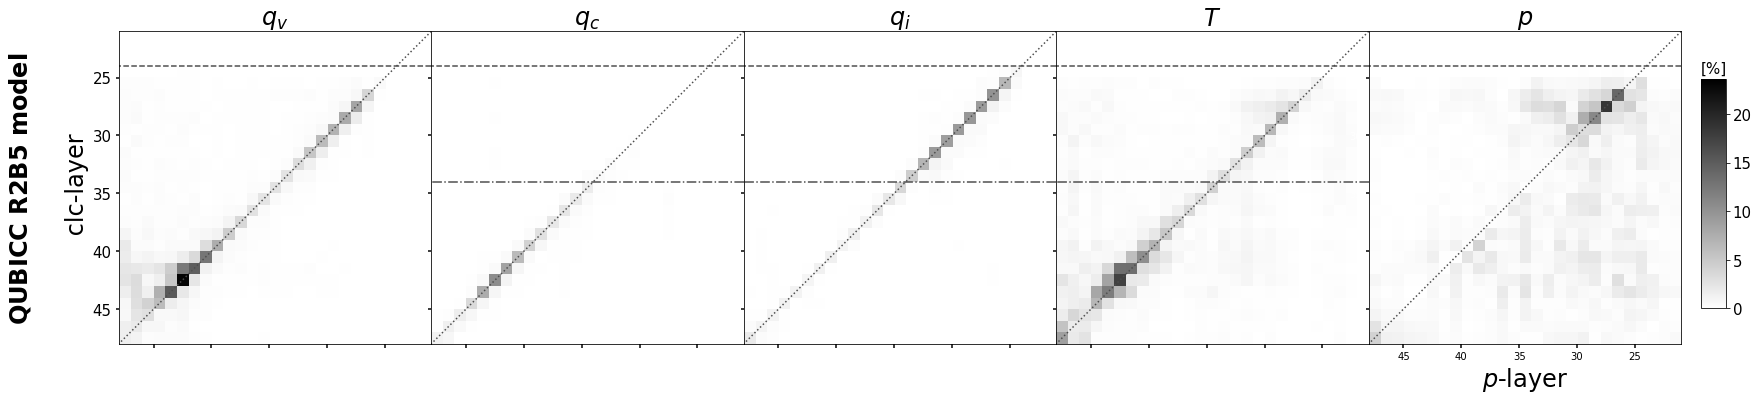

zg r2b5 has absolute SHAP values below 0.697
fr_land r2b5 has absolute SHAP values below 0.096



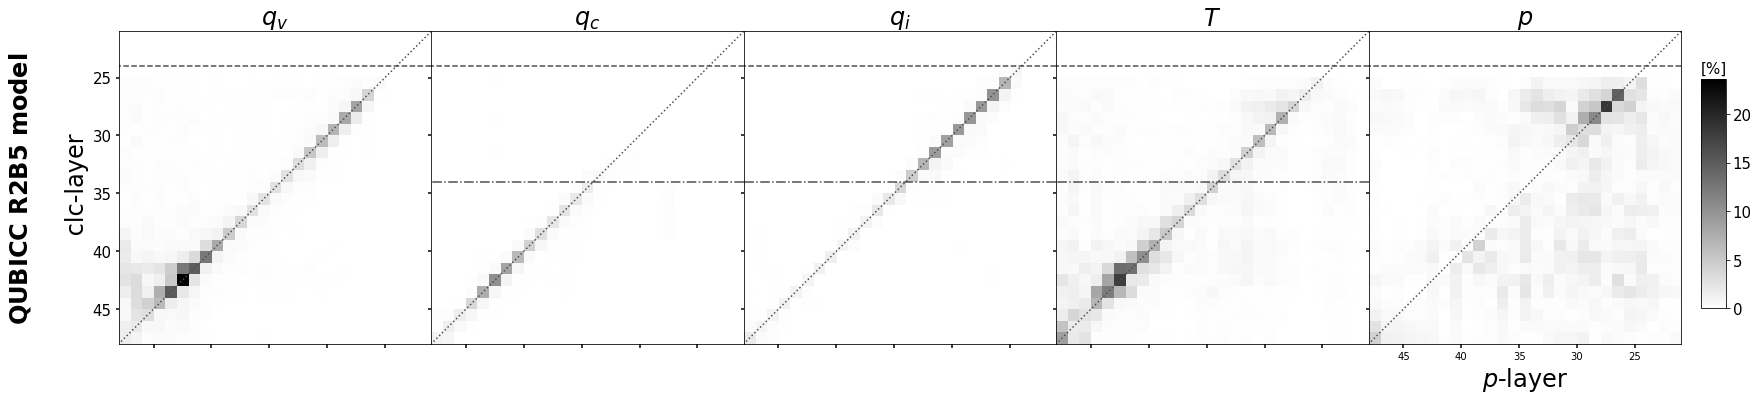

zg r2b5 has absolute SHAP values below 0.697
fr_land r2b5 has absolute SHAP values below 0.096



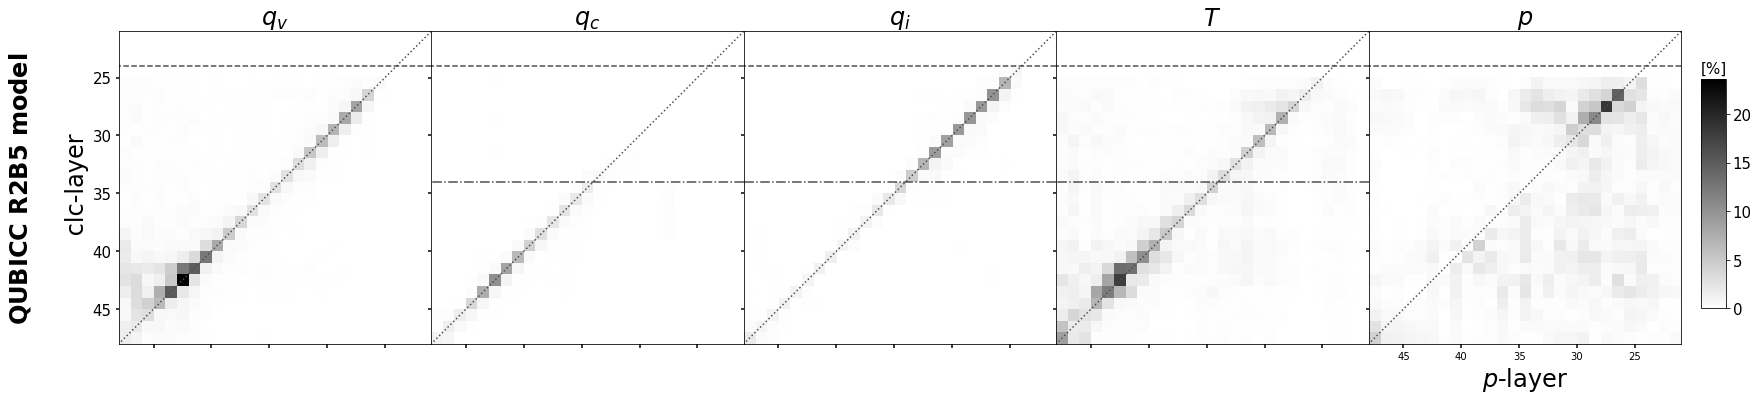

zg r2b5 has absolute SHAP values below 0.697
fr_land r2b5 has absolute SHAP values below 0.096



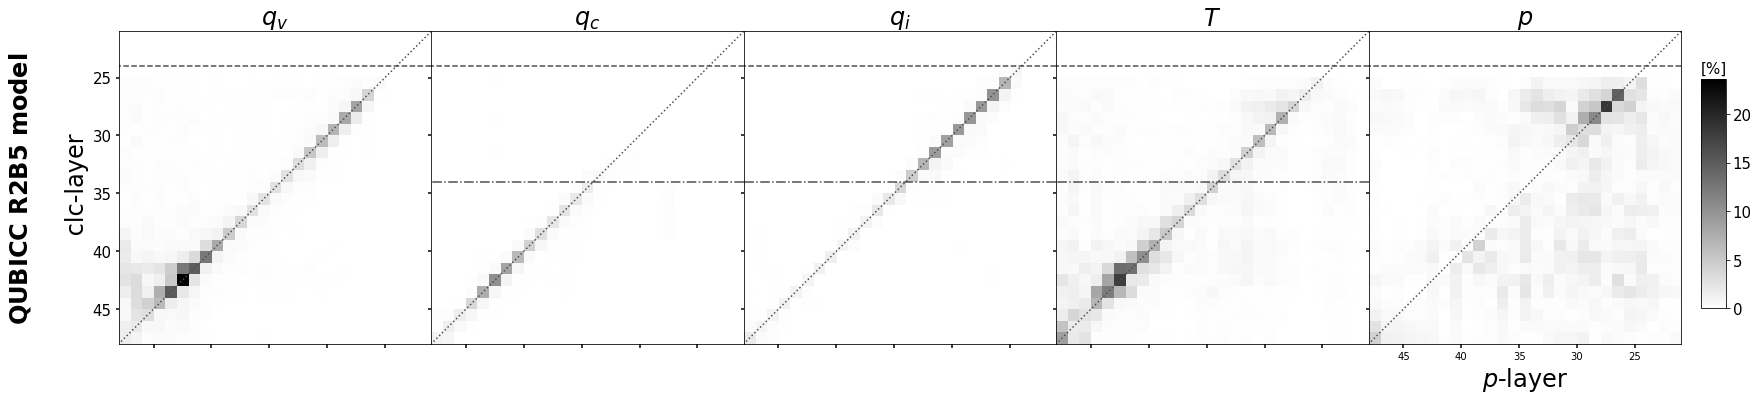

In [14]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(28,11))
# plt.subplots_adjust(bottom=0.1)

label_size = 24 # x-labels, y-labels and titles
tick_label_size = 15

## R2B5 ##

# # To be able to compare the SHAP value colorbar with the one from the R2B4 model, we need to add the difference of the 
# # QUBICC-base and the NARVAL-base value to vmax!
# # According to pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/additional_content/plots_offline_paper/r2b4_mean_clc.ipynb
# # the base value for NARVAL is 3.625 and for QUBICC acc. to qubicc_models_plots.ipynb is 9 (average data_mean_column_clc_qubicc)
# qubicc_base = 9
# narval_base = 3.625
# vmax_r2b4 = 8

# vmin = 0
# vmax = vmax_r2b4 + qubicc_base - narval_base

vmin = 0
vmax_r2b4 = np.max(mean_abs_shap_values_r2b5) 
vmax = vmax_r2b4

cmap_abs = LinearSegmentedColormap.from_list("", ["white","black"])

for k in range(4):
    fig = plt.figure(figsize=(28,11))
    
    # First plot
    ax = fig.add_subplot(151)
    plt.title('$q_v$', fontsize=label_size)
    plt.ylabel(r"$\bf{QUBICC\ R2B5\ model}$" + '\n \n clc-layer', fontsize=label_size)
    ax.plot([21, 48], [21, 48], ls=":", c=".3") # Diagonal
    ax.plot([21, 48], [24, 24], ls="--", c=".3") # Tropopause
    plt.xticks(color='w')
    plt.tick_params(axis='both', labelsize=tick_label_size, width=1.5)
    im_r2b5 = ax.imshow(np.flip(all_abs_shap_values[k][:, :27], axis=1), extent=(48,21,48,21), 
                   vmin=0, vmax=vmax, cmap=cmap_abs)

    # Second plot
    ax = fig.add_subplot(152)
    plt.title('$q_c$', fontsize=label_size)
    ax.plot([21, 48], [21, 48], ls=":", c=".3") # Diagonal
    ax.plot([21, 48], [24, 24], ls="--", c=".3") # Tropopause
    ax.plot([21, 48], [34, 34], ls="-.", c=".3") # Freezing level
    plt.xticks(color='w')
    plt.yticks(color='w')
    plt.tick_params(axis='both', width=1.5)
    im_r2b5 = ax.imshow(np.flip(all_abs_shap_values[k][:, 27:54], axis=1), extent=(48,21,48,21), 
                   vmin=0, vmax=vmax, cmap=cmap_abs)

    # Third plot
    ax = fig.add_subplot(153)
    plt.title('$q_i$', fontsize=label_size)
    ax.plot([21, 48], [21, 48], ls=":", c=".3") # Diagonal
    ax.plot([21, 48], [24, 24], ls="--", c=".3") # Tropopause
    ax.plot([21, 48], [34, 34], ls="-.", c=".3") # Freezing level
    plt.xticks(color='w')
    plt.yticks(color='w')
    plt.tick_params(axis='both', width=1.5)
    im_r2b5 = ax.imshow(np.flip(all_abs_shap_values[k][:, 54:81], axis=1), extent=(48,21,48,21), 
                   vmin=0, vmax=vmax, cmap=cmap_abs)

    # Forth plot
    ax = fig.add_subplot(154)
    plt.title('$T$', fontsize=label_size)
    ax.plot([21, 48], [21, 48], ls=":", c=".3") # Diagonal
    ax.plot([21, 48], [24, 24], ls="--", c=".3") # Tropopause
    ax.plot([21, 48], [34, 34], ls="-.", c=".3") # Freezing level
    plt.xticks(color='w')
    plt.yticks(color='w')
    plt.tick_params(axis='both', width=1.5)
    im_r2b5 = ax.imshow(np.flip(all_abs_shap_values[k][:, 81:108], axis=1), extent=(48,21,48,21), 
                       vmin=0, vmax=vmax, cmap=cmap_abs)

    # Fifth plot
    ax = fig.add_subplot(155)
    plt.xlabel('$p$-layer', fontsize=label_size)
    plt.title('$p$', fontsize=label_size)
    ax.plot([21, 48], [21, 48], ls=":", c=".3") # Diagonal
    ax.plot([21, 48], [24, 24], ls="--", c=".3") # Tropopause
    # plt.xticks(color='w')
    plt.yticks(color='w')
    plt.tick_params(axis='both', width=1.5)
    im_r2b5 = ax.imshow(np.flip(all_abs_shap_values[k][:, 108:135], axis=1), extent=(48,21,48,21), 
                   vmin=0, vmax=vmax, cmap=cmap_abs)

    print('zg r2b5 has absolute SHAP values below %.3f'%np.max(all_abs_shap_values[k][:, 135:162]))

    print('fr_land r2b5 has absolute SHAP values below %.3f\n'%np.max(all_abs_shap_values[k][:, 162]))

    plt.subplots_adjust(wspace=0, hspace=0.2)

    # # Colorbar axes
    cbar_ax = fig.add_axes([0.91, 0.35, 0.012, 0.29])  # The dimensions [left, bottom, width, height] of the new axes. All
                                                       # quantities are in fractions of figure width and height.
    cb_r2b5 = fig.colorbar(im_r2b5, cax=cbar_ax)
    cb_r2b5.ax.tick_params(labelsize=tick_label_size)
    cb_r2b5.ax.set_title('[%]', fontsize=tick_label_size)
    
    plt.show()

In [16]:
# Maximum difference between absolute average SHAP values
maxima = []
for k in range(4):
    for j in range(4):
        m = np.max(np.abs(all_abs_shap_values[k] - all_abs_shap_values[j]))
        maxima.append(m)

# Used in the description of Figure 9
max(maxima) #k=0, j=2

0.53125

In [100]:
# Maximum differences sorted
-np.sort(-np.reshape(np.abs(all_abs_shap_values[0] - all_abs_shap_values[2]), -1))

array([2.469, 2.141, 1.723, ..., 0.000, 0.000, 0.000])

In [101]:
# Eight entries have SHAP values differences greater than 1
-np.sort(-np.reshape(np.abs(all_abs_shap_values[0] - all_abs_shap_values[2]), -1))[:9]

array([2.469, 2.141, 1.723, 1.328, 1.297, 1.234, 1.039, 1.031, 0.938])

In [102]:
# Correspoding args
args_1d = np.argsort(-np.reshape(np.abs(all_abs_shap_values[0] - all_abs_shap_values[2]), -1))[:9]
args_2d = np.unravel_index(args_1d, all_abs_shap_values[0].shape)

In [103]:
# Relative errors
for i in range(8):
    ind = args_2d[0][i], args_2d[1][i]
    rel_err = (np.abs(all_abs_shap_values[0] - all_abs_shap_values[2])[ind]/np.abs(all_abs_shap_values[0])[ind])
    print(rel_err)

0.07923771313941826
0.08616352201257861
0.1975806451612903
0.06088825214899714
0.06292645943896892
0.08342133051742344
0.08359522313010685
0.049107142857142856


In [118]:
constructed_base = False
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

if constructed_base:
    r2b5_file = '/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/grid_column_based_QUBICC_R02B05/source_code/shap_values_fold_2_constructed_base_value.txt'
else:
    r2b5_file = '/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/grid_column_based_QUBICC_R02B05/source_code/shap_values_fold_2.txt'

In [119]:
with open(r2b5_file, 'r') as file:
    lines = file.readlines()

if constructed_base:
    start_read_ind_r2b5 = 11
else:
    start_read_ind_r2b5 = 36 
print(lines[start_read_ind_r2b5])

if constructed_base:
    start_read_ind_r2b5 += 2

print(lines[start_read_ind_r2b5+6])
masv = lines[start_read_ind_r2b5+7].split('[')

mean_abs_shap_values_r2b5 = np.zeros((27, 154))

for layer in range(1, 28):
    mean_abs_shap_values_r2b5[layer-1] = np.fromstring(masv[layer][:-1], dtype=np.float16, sep=',')

# Add the removed fields
for i in range(6):
    mean_abs_shap_values_r2b5 = np.insert(mean_abs_shap_values_r2b5, 27, np.zeros(27), axis=1)

for i in range(3):
    mean_abs_shap_values_r2b5 = np.insert(mean_abs_shap_values_r2b5, 135, np.zeros(27), axis=1)

all_abs_shap_values.append(mean_abs_shap_values_r2b5)

Number of NARVAL samples: 10000

Mean absolute SHAP values:



string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.


zg r2b5 has absolute SHAP values below 0.694
fr_land r2b5 has absolute SHAP values below 0.097



<Figure size 2016x792 with 0 Axes>

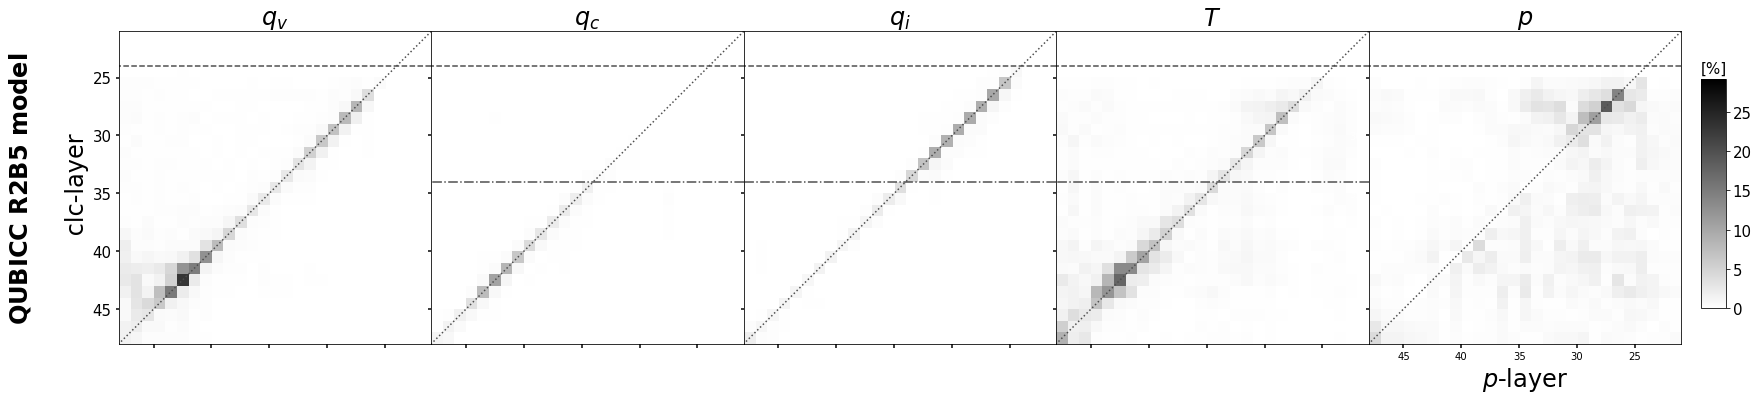

In [120]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(28,11))
# plt.subplots_adjust(bottom=0.1)

label_size = 24 # x-labels, y-labels and titles
tick_label_size = 15

## R2B5 ##

# # To be able to compare the SHAP value colorbar with the one from the R2B4 model, we need to add the difference of the 
# # QUBICC-base and the NARVAL-base value to vmax!
# # According to pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/additional_content/plots_offline_paper/r2b4_mean_clc.ipynb
# # the base value for NARVAL is 3.625 and for QUBICC acc. to qubicc_models_plots.ipynb is 9 (average data_mean_column_clc_qubicc)
# qubicc_base = 9
# narval_base = 3.625
# vmax_r2b4 = 8

# vmin = 0
# vmax = vmax_r2b4 + qubicc_base - narval_base

vmin = 0
vmax_r2b4 = 29.2
vmax = 29.2

cmap_abs = LinearSegmentedColormap.from_list("", ["white","black"])

k = 10

fig = plt.figure(figsize=(28,11))

# First plot
ax = fig.add_subplot(151)
plt.title('$q_v$', fontsize=label_size)
plt.ylabel(r"$\bf{QUBICC\ R2B5\ model}$" + '\n \n clc-layer', fontsize=label_size)
ax.plot([21, 48], [21, 48], ls=":", c=".3") # Diagonal
ax.plot([21, 48], [24, 24], ls="--", c=".3") # Tropopause
plt.xticks(color='w')
plt.tick_params(axis='both', labelsize=tick_label_size, width=1.5)
im_r2b5 = ax.imshow(np.flip(all_abs_shap_values[k][:, :27], axis=1), extent=(48,21,48,21), 
               vmin=0, vmax=vmax, cmap=cmap_abs)

# Second plot
ax = fig.add_subplot(152)
plt.title('$q_c$', fontsize=label_size)
ax.plot([21, 48], [21, 48], ls=":", c=".3") # Diagonal
ax.plot([21, 48], [24, 24], ls="--", c=".3") # Tropopause
ax.plot([21, 48], [34, 34], ls="-.", c=".3") # Freezing level
plt.xticks(color='w')
plt.yticks(color='w')
plt.tick_params(axis='both', width=1.5)
im_r2b5 = ax.imshow(np.flip(all_abs_shap_values[k][:, 27:54], axis=1), extent=(48,21,48,21), 
               vmin=0, vmax=vmax, cmap=cmap_abs)

# Third plot
ax = fig.add_subplot(153)
plt.title('$q_i$', fontsize=label_size)
ax.plot([21, 48], [21, 48], ls=":", c=".3") # Diagonal
ax.plot([21, 48], [24, 24], ls="--", c=".3") # Tropopause
ax.plot([21, 48], [34, 34], ls="-.", c=".3") # Freezing level
plt.xticks(color='w')
plt.yticks(color='w')
plt.tick_params(axis='both', width=1.5)
im_r2b5 = ax.imshow(np.flip(all_abs_shap_values[k][:, 54:81], axis=1), extent=(48,21,48,21), 
               vmin=0, vmax=vmax, cmap=cmap_abs)

# Forth plot
ax = fig.add_subplot(154)
plt.title('$T$', fontsize=label_size)
ax.plot([21, 48], [21, 48], ls=":", c=".3") # Diagonal
ax.plot([21, 48], [24, 24], ls="--", c=".3") # Tropopause
ax.plot([21, 48], [34, 34], ls="-.", c=".3") # Freezing level
plt.xticks(color='w')
plt.yticks(color='w')
plt.tick_params(axis='both', width=1.5)
im_r2b5 = ax.imshow(np.flip(all_abs_shap_values[k][:, 81:108], axis=1), extent=(48,21,48,21), 
                   vmin=0, vmax=vmax, cmap=cmap_abs)

# Fifth plot
ax = fig.add_subplot(155)
plt.xlabel('$p$-layer', fontsize=label_size)
plt.title('$p$', fontsize=label_size)
ax.plot([21, 48], [21, 48], ls=":", c=".3") # Diagonal
ax.plot([21, 48], [24, 24], ls="--", c=".3") # Tropopause
# plt.xticks(color='w')
plt.yticks(color='w')
plt.tick_params(axis='both', width=1.5)
im_r2b5 = ax.imshow(np.flip(all_abs_shap_values[k][:, 108:135], axis=1), extent=(48,21,48,21), 
               vmin=0, vmax=vmax, cmap=cmap_abs)

print('zg r2b5 has absolute SHAP values below %.3f'%np.max(all_abs_shap_values[k][:, 135:162]))

print('fr_land r2b5 has absolute SHAP values below %.3f\n'%np.max(all_abs_shap_values[k][:, 162]))

plt.subplots_adjust(wspace=0, hspace=0.2)

# # Colorbar axes
cbar_ax = fig.add_axes([0.91, 0.35, 0.012, 0.29])  # The dimensions [left, bottom, width, height] of the new axes. All
                                                   # quantities are in fractions of figure width and height.
cb_r2b5 = fig.colorbar(im_r2b5, cax=cbar_ax)
cb_r2b5.ax.tick_params(labelsize=tick_label_size)
cb_r2b5.ax.set_title('[%]', fontsize=tick_label_size)

plt.show()

One of the plots from above:
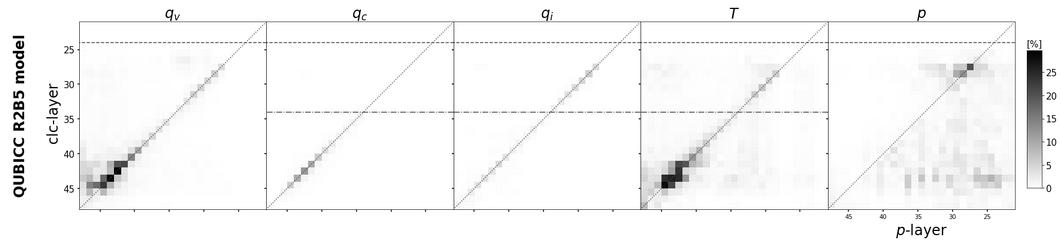

In [110]:
# Maximum difference between absolute average SHAP values
maxima = []
for k in range(11):
    for j in range(11):
        m = np.max(np.abs(all_abs_shap_values[k] - all_abs_shap_values[j]))
        maxima.append(m)

max(maxima) #k=0, j=2

23.0

In [124]:
# Maximum differences sorted
-np.sort(-np.reshape(np.abs(all_abs_shap_values[0] - all_abs_shap_values[10]), -1))

array([22.766, 18.266, 17.770, ..., 0.000, 0.000, 0.000])

In [125]:
# Eight entries have SHAP values differences greater than 1
-np.sort(-np.reshape(np.abs(all_abs_shap_values[0] - all_abs_shap_values[10]), -1))[:9]

array([22.766, 18.266, 17.770, 17.254, 16.648, 14.586, 14.320, 13.137,
       11.562])

In [126]:
# Correspoding args
args_1d = np.argsort(-np.reshape(np.abs(all_abs_shap_values[0] - all_abs_shap_values[10]), -1))[:9]
args_2d = np.unravel_index(args_1d, all_abs_shap_values[0].shape)

In [128]:
# Relative errors
for i in range(8):
    ind = args_2d[0][i], args_2d[1][i]
    rel_err = (np.abs(all_abs_shap_values[0] - all_abs_shap_values[10])[ind]/np.abs(all_abs_shap_values[0])[ind])
    print(rel_err)

0.7700845665961945
0.8697916666666666
0.721147748890298
0.7356762158560959
0.670125786163522
0.545906432748538
0.4826224328593997
0.7560701438848921


**==> Even the absolute average SHAP plots with the native base value are qualitatively very similar (see SI).**